Q3: Implementation of Neural Networks from Scratch Using NumPy and Comparison with Sklearn (20 marks):
  
    1. Load and preprocess the MNIST Digits Dataset. (3 marks)
    2. Implement a neural network with one input layer, one hidden layer, and one output layer using NumPy. (5 marks)
    3. Train the neural network with various hyperparameters (e.g., learning rate, number of hidden nodes). (3 marks)
    4. Evaluate the performance of the neural network on the testing set. (2 marks)
    5. Implement the same neural network using sklearn and compare the results with the NumPy implementation. (4 marks)
    6. Plot the training and validation loss/accuracy curves (for both experiments). (3 marks)



In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings,gc,sys
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import tensorflow as tf
device_name = tf.test.gpu_device_name()
from pprint import pprint

In [2]:
while True:
    try:
        mnist_784_df = pd.read_csv("mnist_784.csv")
        break
    except FileNotFoundError:
        from sklearn.datasets import fetch_openml

        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X["Y"] = y
        X.to_csv("mnist_784.csv",index=False,header=True)
        del X,y
# %%script echo skipping

In [61]:
import tensorflow as tf
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess data
def preprocess(x, y):
    x = tf.reshape(x, shape=(-1, 28*28))  # Flatten images to 784-dimensional vectors
    x = tf.cast(x, tf.float32) / 255.0    # Normalize pixel values
    y = tf.one_hot(y, depth=10)           # One-hot encode labels
    return x, y

# Prepare datasets
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocess).batch(128)
# test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocess).batch(128)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [62]:
# Initialize parameters manually (no Keras layers)
input_size = 784
hidden_size = 256
output_size = 10

# Weights and biases for hidden layer 1
W1 = tf.Variable(tf.random.truncated_normal([input_size, hidden_size], stddev=0.1))
b1 = tf.Variable(tf.zeros([hidden_size]))

# Weights and biases for output layer
W2 = tf.Variable(tf.random.truncated_normal([hidden_size, output_size], stddev=0.1))
b2 = tf.Variable(tf.zeros([output_size]))

In [63]:
def forward(x):
    x = tf.reshape(x, shape=(-1, input_size))
    # Hidden layer with ReLU activation
    z1 = tf.matmul(x, W1) + b1
    a1 = tf.nn.relu(z1)

    # Output layer (logits)
    logits = tf.matmul(a1, W2) + b2
    return logits

In [59]:
# Loss function (cross-entropy)
loss_fn = tf.losses.CategoricalCrossentropy(from_logits=True)

# Optimizer (Adam)
optimizer = tf.optimizers.Adam(learning_rate=0.001)

In [64]:
epochs = 10**3
with tf.device('/device:GPU:0'):
    for epoch in range(epochs):
        total_loss = 0.0

        # Training loop
        for x_batch, y_batch in train_data:
            with tf.GradientTape() as tape:
                logits = forward(x_batch)
                loss = loss_fn(y_batch, logits)

            # Compute gradients and update weights
            gradients = tape.gradient(loss, [W1, b1, W2, b2])
            optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2]))
            total_loss += loss.numpy()

        # Print epoch loss
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_data):.4f}")

Epoch 1/1000, Loss: 0.3271
Epoch 2/1000, Loss: 0.1419
Epoch 3/1000, Loss: 0.0968


KeyboardInterrupt: 

In [3]:
def sigmoid(x):
    return tf.sigmoid(x)

def sigmoid_derivative(x):
    return x * (1 - x)  # Remains the same

def relu(x):
    return tf.nn.relu(x)

def relu_derivative(x):
    return tf.cast(tf.greater(x, 0), tf.float32)

In [35]:
inputs = mnist_784_df.drop(columns="Y").values
targets = mnist_784_df["Y"].values
result = np.where(targets == 5, 1, 0)

IL_n = mnist_784_df.shape[-1]-1
n_neurons_HL = int(np.sqrt(IL_n-1))
print(IL_n,n_neurons_HL)

784 27


In [37]:
# Normalize the array
max_values = np.max(inputs, axis=0)
min_values = np.min(inputs, axis=0)

normalized_array = (inputs - min_values) / (max_values - min_values)
normalized_array = np.nan_to_num(normalized_array)  # Replace NaN values with 0

# normalized_array = tf.convert_to_tensor(normalized_array, dtype=tf.float32)
# targets = tf.reshape(tf.convert_to_tensor(targets, dtype=tf.float32),shape = (-1,1))

# import matplotlib.pyplot as plt
# index = 101
# print(normalized_array[index])
# plt.imshow(normalized_array[index].reshape(28, 28), cmap='gray')
# plt.title(f'{result[index]}')
# plt.show()

scaler = StandardScaler()
inputs = pd.DataFrame(scaler.fit_transform(inputs), columns=inputs)

In [38]:
%%script echo skipping
# # Create a tf.data.Dataset from your data
# dataset = tf.data.Dataset.from_tensor_slices((normalized_array, targets))

# # Split the dataset into train and test sets
# train_dataset, test_dataset = tf.keras.utils.split_dataset(
#     dataset,
#     left_size=0.8,  # Proportion for the train set (80% in this case)
#     right_size=0.2,  # Proportion for the test set (20% in this case)
#     shuffle=True, seed = 42
# )

skipping


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    normalized_array, result,
    test_size=0.20, random_state=42,
    stratify=result,shuffle=True)

In [39]:
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)


(56000, 784)
(14000, 784)
(56000,)
(14000,)


In [40]:
# X_train, X_test, y_train, y_test

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

y_train = tf.reshape(tf.convert_to_tensor(y_train, dtype=tf.float32),shape = (-1,1))
y_test = tf.reshape(tf.convert_to_tensor(y_test, dtype=tf.float32),shape = (-1,1))

In [41]:
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)


(56000, 784)
(14000, 784)
(56000, 1)
(14000, 1)


In [43]:
# Get unique values and their counts
for i in y_train, y_test:
    unique_values, _, counts = tf.unique_with_counts(tf.reshape(i,shape = (-1,)))

    # Print the results
    print("Unique Values:", unique_values.numpy())
    print("Counts:", counts.numpy())

Unique Values: [0. 1.]
Counts: [50950  5050]
Unique Values: [0. 1.]
Counts: [12737  1263]


In [54]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim,inputs, targets):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.inputs = inputs
        # tf.convert_to_tensor(inputs, dtype=tf.float32)
        self.targets = targets
        # tf.convert_to_tensor(targets.reshape(-1, 1), dtype=tf.float32)

        self.weights1 = tf.random.normal((self.input_dim, self.hidden_dim))
        self.weights2 = tf.random.normal((self.hidden_dim, self.output_dim))
        self.bias1 = tf.zeros((1, self.hidden_dim))
        self.bias2 = tf.zeros((1, self.output_dim))

    def sigmoid(self,x):
        return tf.sigmoid(x)
    def sigmoid_derivative(self,x):
        return x * (1 - x)
    def relu(self,x):
        return tf.nn.relu(x)
    def relu_derivative(self,x):
        return tf.cast(tf.greater(x, 0), tf.float32)

    def forward_propagation(self,input ):

        hidden_layer_input = tf.matmul(input, self.weights1) + self.bias1
        self.hidden_layer_output = tf.nn.relu(hidden_layer_input)

        output_layer_input = tf.matmul(self.hidden_layer_output, self.weights2) + self.bias2
        self.output_layer_output = tf.sigmoid(output_layer_input)

        # # print(tf.reshape(y_pred,shape = (-1,)))
        # condition = tf.greater(self.output_layer_output, .5)  # threshold
        # indices = tf.where(condition)          # Get indices where condition is True

        # # # Equivalent to np.where(tensor_data > 3, tensor_data, 0)
        # y_pred = tf.where(condition, 1, tf.zeros_like(self.output_layer_output))

        # # Get unique values and their counts
        # unique_values, _, counts = tf.unique_with_counts(tf.reshape(y_pred,shape = (-1,)))

        # # Print the results
        # print("Unique Values:", unique_values.numpy())
        # print("Counts:", counts.numpy())
        # sys.exit()

    def backward_propagation(self):

        d_output =self.output_layer_output - self.targets

        self.d_weights2 = tf.matmul(tf.transpose(self.hidden_layer_output), d_output * self.sigmoid_derivative(self.output_layer_output))

        self.d_bias2 = tf.reduce_sum(d_output * self.sigmoid_derivative(self.output_layer_output), axis=0, keepdims=True)

        d_hidden_layer = tf.matmul(d_output * self.sigmoid_derivative(self.output_layer_output), tf.transpose(self.weights2)) * self.relu_derivative(self.hidden_layer_output)

        self.d_weights1 = tf.matmul(tf.transpose(self.inputs), d_hidden_layer)
        self.d_bias1 = tf.reduce_sum(d_hidden_layer, axis=0, keepdims=True)

    def update_weights(self,learning_rate):

        self.weights1 -= learning_rate * self.d_weights1
        self.bias1 -= learning_rate * self.d_bias1
        self.weights2 -= learning_rate * self.d_weights2
        self.bias2 -= learning_rate * self.d_bias2

    def fit(self, epochs, learning_rate):

        for epoch in tqdm(range(epochs),leave=False):

            self.forward_propagation(input=self.inputs)
            self.backward_propagation()
            self.update_weights(learning_rate=learning_rate)

                # Print loss every 1000 epochs
            if epoch % (epochs//10) == 0:
                loss = tf.reduce_mean(tf.square(self.output_layer_output - self.targets))
                print(f"\nEpoch {epoch+1}, Loss: {loss}")
                # gc.collect()

        # _, final_output =
    def predict(self,input):
            self.forward_propagation(input=tf.convert_to_tensor(input, dtype=tf.float32))
            # print("Final Predictions:")
            return self.output_layer_output
            # print(self.output_layer_output)

In [55]:
%%time
with tf.device('/device:GPU:0'):
    nn = NeuralNetwork(input_dim=IL_n, hidden_dim=n_neurons_HL, output_dim=1,inputs=X_train,targets=y_train)
    # X_train, X_test, y_train, y_test
    learning_rate = 0.01
    epochs = 10**3
    nn.fit(epochs, learning_rate)

Unique Values: [1. 0.]
Counts: [30108 25892]


SystemExit: 

In [46]:
y_pred = nn.predict(input=X_test)
print(y_pred)
# print(tf.reshape(y_pred,shape = (-1,)))
# condition = tf.greater(y_pred, .5)  # threshold
# indices = tf.where(condition)          # Get indices where condition is True

# # # Equivalent to np.where(tensor_data > 3, tensor_data, 0)
# y_pred = tf.where(condition, y_pred, tf.zeros_like(y_pred))

tf.Tensor(
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]], shape=(14000, 1), dtype=float32)


In [47]:
# Get unique values and their counts
unique_values, _, counts = tf.unique_with_counts(tf.reshape(y_pred,shape = (-1,)))

# Print the results
print("Unique Values:", unique_values.numpy())
print("Counts:", counts.numpy())

Unique Values: [0.]
Counts: [14000]


In [13]:
# y_test = tf.reshape(y_test,shape = (-1,1))

In [36]:
# tf.reshape(y_pred,shape = (-1,1))

In [46]:
# from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.91


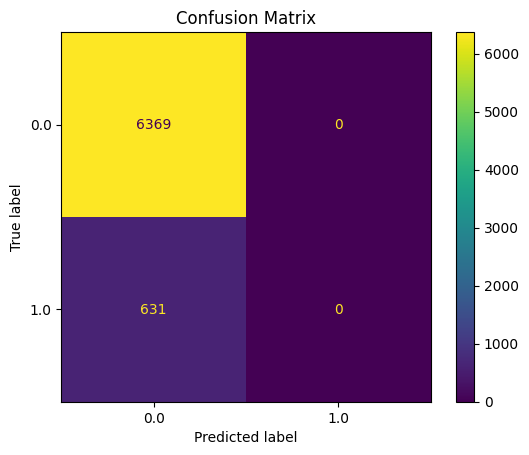


Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      6369
         1.0       0.00      0.00      0.00       631

    accuracy                           0.91      7000
   macro avg       0.45      0.50      0.48      7000
weighted avg       0.83      0.91      0.87      7000



In [48]:
cm = confusion_matrix(y_test, y_pred)
# Get the unique class labels from y_test
unique_labels = np.unique(y_test)
# Use unique_labels for display_labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=unique_labels.astype(str))) # Convert to string for report

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
sys.exit()

In [ ]:
nn = NeuralNetwork(input_dim=IL_n, hidden_dim=n_neurons_HL, output_dim=1,input=inputs,targets=targets)


learning_rate = 0.1
epochs = 10000

for epoch in range(epochs):
    hidden_layer_output, output_layer_output = nn.forward_propagation(inputs)
    d_weights1, d_bias1, d_weights2, d_bias2 = nn.backward_propagation(inputs, targets, hidden_layer_output, output_layer_output)
    nn.update_weights(d_weights1, d_bias1, d_weights2, d_bias2, learning_rate)

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        loss = np.mean(np.square(output_layer_output - targets))
        print(f"Epoch {epoch+1}, Loss: {loss}")

# Final predictions
_, final_output = nn.forward_propagation(inputs)
print("Final Predictions:")
print(final_output)


In [ ]:
class Neuron:
    def __init__(self,value):
        self.value = value
class hidden_layer


In [ ]:
class aHL:
    def __init__(self,mnist_784_df):


    def forward_prop_relu(self,input,weight):
        return np.maximum(0, input*weight)




In [ ]:
X.to_csv("mnist_784.csv",index=False,header=True)

In [ ]:
display(X.head().T)

In [ ]:
df = pd.DataFrame(X, columns=[f'Pixel_{i}'for i in range(X.shape[-1])])

In [ ]:
display(df.head())

In [ ]:
y.head()

In [ ]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim,inputs, targets):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.inputs = inputs
        self.targets = targets

        self.weights1 = np.random.rand(input_dim, hidden_dim)
        self.weights2 = np.random.rand(hidden_dim, output_dim)
        self.bias1 = np.zeros((1, hidden_dim))
        self.bias2 = np.zeros((1, output_dim))

    def forward_propagation(self):

        hidden_layer_input = np.dot(self.inputs, self.weights1) + self.bias1
        hidden_layer_output = relu(hidden_layer_input)

        output_layer_input = np.dot(hidden_layer_output, self.weights2) + self.bias2
        output_layer_output = sigmoid(output_layer_input)

        return hidden_layer_output, output_layer_output

    def backward_propagation(self, targets, hidden_layer_output, output_layer_output):

        d_output = 2 * (output_layer_output - targets)
        d_weights2 = np.dot(hidden_layer_output.T, d_output * sigmoid_derivative(output_layer_output))
        d_bias2 = np.sum(d_output * sigmoid_derivative(output_layer_output), axis=0, keepdims=True)

        d_hidden_layer = np.dot(d_output * sigmoid_derivative(output_layer_output), self.weights2.T) * relu_derivative(hidden_layer_output)
        d_weights1 = np.dot(self.inputs.T, d_hidden_layer)
        d_bias1 = np.sum(d_hidden_layer, axis=0, keepdims=True)

        return d_weights1, d_bias1, d_weights2, d_bias2

    def update_weights(self, d_weights1, d_bias1, d_weights2, d_bias2, learning_rate):
        self.weights1 -= learning_rate * d_weights1
        self.bias1 -= learning_rate * d_bias1
        self.weights2 -= learning_rate * d_weights2
        self.bias2 -= learning_rate * d_bias2

    def runner(self, epochs, learning_rate):
        # inputs, targets, epochs, learning_rate
        for i in range(epochs):
            # hidden_layer_output, output_layer_output = self.forward_propagation(inputs)
            # d_weights1, d_bias1, d_weights2, d_bias2 = self.backward_propagation(inputs, targets, hidden_layer_output, output_layer_output)
            # self.update_weights(d_weights1, d_bias1, d_weights2, d_bias2, learning_rate)

            self.forward_propagation()
            self.backward_propagation()
            self.update_weights()

            if i % 100 == 0:
                print(f"Loss: {np.mean(np.square(output_layer_output - targets))}")